
[시계열 예측 1: Prophet 모델 입문]에 대한 상세 강의 자료와 실습 노트북이다.

이 시간의 핵심은 복잡한 통계 이론(ARIMA 등)에 얽매이지 않고, 비전공자도 쉽게 미래를 예측할 수 있는 강력한 도구인 Prophet을 경험해보는 것이다. 이를 통해 학생들이 "나도 미래 데이터를 만들어낼 수 있다!"는 성취감을 느끼게 하는 것이 목표이다.

---

# 📘 Prophet과 함께 하는 미래 예측

## 1. 예측(Forecasting)이란?
*   정의: 과거 데이터의 패턴을 학습하여, 미래에 발생할 값을 추정하는 작업이다.
*   헬스케어에서의 필요성:
    *   병원 운영: "내년 독감 시즌에 환자가 얼마나 몰릴까?" $\rightarrow$ 병상, 인력, 약품 확보
    *   공중 보건: "다음 달 코로나19 확진자 수는 어떻게 될까?" $\rightarrow$ 방역 정책 수립
    *   개인 건강: "이 환자의 혈당이 3시간 뒤 위험 수치에 도달할까?" $\rightarrow$ 사전 조치

## 2. 전통적인 통계 모델(ARIMA)의 어려움
*   ARIMA, SARIMA 등 전통적인 통계 모델은 예측 성능이 뛰어나지만, 사용하기가 매우 까다롭다.
    *   데이터를 안정적(Stationary)으로 변환해야 함 (차분 등)
    *   최적의 파라미터(p, d, q)를 찾기 위해 전문적인 지식이 필요함
    *   휴일(Holiday)이나 특별 이벤트 효과를 반영하기 어려움

## 3. Prophet: 비전문가를 위한 예측 도구
*   개발: 페이스북(현 Meta)에서 개발한 오픈소스 라이브러리.
*   철학: "복잡한 파라미터 튜닝은 기계에게 맡기고, 사람은 비즈니스 지식(휴일, 이벤트 등)을 모델에 쉽게 추가할 수 있어야 한다."
*   장점:
    1.  사용이 매우 쉽다: 단 몇 줄의 코드로 준수한 성능의 모델을 만든다.
    2.  자동화: 데이터의 추세(Trend) 변화점, 계절성(Seasonality) 패턴을 자동으로 탐지한다.
    3.  해석이 용이하다: 예측 결과가 `추세 + 주간 계절성 + 연간 계절성 + 휴일 효과`로 분해되어 나와서, "왜 이렇게 예측했는지" 이해하기 쉽다.

## 4. Prophet의 작동 원리 (직관적 이해)
Prophet은 시계열 데이터를 4가지 성분으로 분해하여 예측한다. (5교시에 배운 시계열 분해와 동일한 개념)
*   $y(t) = g(t) + s(t) + h(t) + \epsilon_t$
    *   $g(t)$ (Growth, 추세): 데이터가 전체적으로 성장하는지, 감소하는지, 아니면 안정적인지 파악한다.
    *   $s(t)$ (Seasonality, 계절성): 주별(Weekly), 연별(Yearly) 패턴을 찾아낸다. (예: 월요일에 높고 주말에 낮음)
    *   $h(t)$ (Holiday, 휴일): 설날, 추석 등 특별한 날의 효과를 반영한다.
    *   $\epsilon_t$ (Error, 잔차): 위 세 가지로 설명되지 않는 노이즈.

---
---

# 💻 Prophet으로 응급실 내원객 수 예측하기

이 노트북에서는 가상의 일별 응급실 내원객 데이터를 생성하고, Prophet을 이용해 미래 1년 치 환자 수를 예측하는 과정을 실습한다.

### 1. 환경 설정 및 Prophet 설치
Prophet은 기본 라이브러리가 아니므로 별도 설치가 필요하다.



In [1]:
# Prophet 설치
!pip install prophet

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

print("라이브러리 로드 완료.")

라이브러리 로드 완료.


### 2. Prophet에 맞는 데이터 준비
Prophet을 사용하려면 데이터프레임의 컬럼 이름을 반드시 `ds`와 `y`로 맞춰야 한다.
*   `ds`: Datestamp (날짜/시간 정보, 반드시 datetime 형식이어야 함)
*   `y`: 예측하려는 값 (수치)

Prophet 학습용 데이터:


,ds,y
0,2023-01-01,54.668196
1,2023-01-02,53.374719
2,2023-01-03,54.159402
3,2023-01-04,47.625468
4,2023-01-05,48.455005


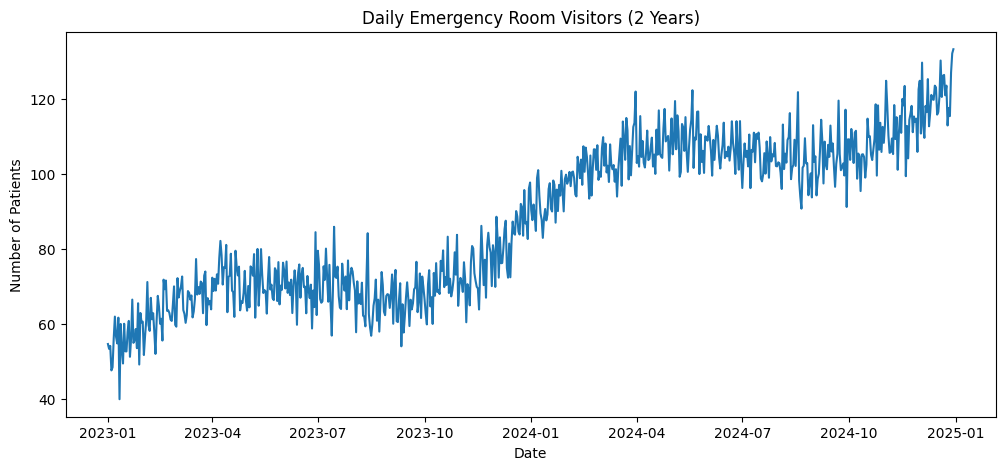

In [2]:
# 2년치(730일) 데이터 생성 (2023-01-01 ~ 2024-12-31)
dates = pd.date_range(start='2023-01-01', periods=730, freq='D')

# 1. 추세(Trend): 서서히 증가 (하루 0.1명씩)
trend = np.arange(len(dates)) * 0.1

# 2. 계절성(Seasonality): 주말(토/일)에 환자가 더 많고, 여름/겨울에 더 많음
weekly_seasonality = 5 * np.isin(dates.dayofweek, [5, 6]) # 토,일=5,6
yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365.25)

# 3. 노이즈
noise = np.random.normal(0, 5, len(dates))

# 4. 최종 데이터
patients = 50 + trend + weekly_seasonality + yearly_seasonality + noise

# Prophet 형식에 맞게 데이터프레임 생성
df = pd.DataFrame({'ds': dates, 'y': patients})

print("Prophet 학습용 데이터:")
display(df.head())

# 시각화: 원본 데이터 확인
plt.figure(figsize=(12, 5))
plt.plot(df['ds'], df['y'])
plt.title("Daily Emergency Room Visitors (2 Years)")
plt.xlabel("Date")
plt.ylabel("Number of Patients")
plt.show()

### 3. Prophet 모델 학습 (Fitting)
모델을 만들고 학습시키는 과정은 단 세 줄이면 끝난다.

In [3]:
# 1. Prophet 모델 객체 생성
# seasonality_mode='multiplicative': 계절성 패턴이 추세에 따라 커지는 경우
m = Prophet(seasonality_mode='additive') # 여기선 간단하게 additive 사용

# 2. 모델 학습 (fit)
# df는 반드시 'ds', 'y' 컬럼을 가져야 한다.
m.fit(df)

print("모델 학습 완료.")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


모델 학습 완료.


### 4. 미래 예측용 데이터프레임 생성
학습된 모델에게 "앞으로 며칠을 예측해줘"라고 알려주는 단계이다.

In [4]:
# make_future_dataframe: 미래 날짜를 자동으로 생성해주는 편리한 함수
# periods=365: 앞으로 365일(1년)을 예측하겠다.
future = m.make_future_dataframe(periods=365)

print("미래 예측용 날짜 데이터 (과거 + 미래):")
display(future.tail())

미래 예측용 날짜 데이터 (과거 + 미래):


,ds
1090,2025-12-26
1091,2025-12-27
1092,2025-12-28
1093,2025-12-29
1094,2025-12-30


### 5. 미래 예측 수행 (Predict)
`predict` 함수를 호출하면 미래 날짜에 대한 예측값이 담긴 데이터프레임이 반환된다.

In [5]:
# 예측 수행
forecast = m.predict(future)

print("예측 결과 (다양한 정보 포함):")
# yhat: 최종 예측값
# yhat_lower, yhat_upper: 예측의 불확실성 구간 (신뢰구간)
# trend, weekly, yearly: 각 구성 요소별 예측값
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

예측 결과 (다양한 정보 포함):


,ds,yhat,yhat_lower,yhat_upper
1090,2025-12-26,152.618867,110.754362,201.955043
1091,2025-12-27,157.846540,118.245497,207.381027
1092,2025-12-28,157.328358,116.678202,206.450826
1093,2025-12-29,153.081543,111.676125,203.958446
1094,2025-12-30,153.256197,110.719310,200.879868


### 6. 예측 결과 시각화
Prophet은 자체적으로 매우 훌륭한 시각화 기능을 제공한다.

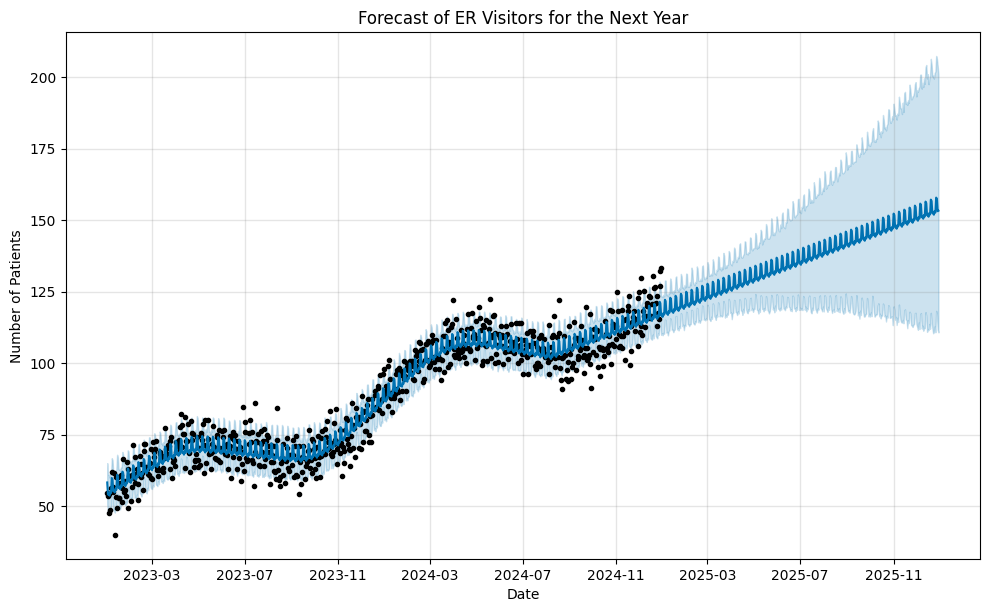

In [6]:
# 1. 전체 예측 결과 그래프
# 검은 점: 실제 데이터
# 파란 선: 예측값 (yhat)
# 연한 파란 영역: 불확실성 구간
fig1 = m.plot(forecast)
plt.title("Forecast of ER Visitors for the Next Year")
plt.xlabel("Date")
plt.ylabel("Number of Patients")
plt.show()

### 📝 실습 과제 (다음 시간에 배울 내용 예고)
Prophet의 진정한 강점은 '해석'에 있다. 다음 코드를 실행하고, 그래프를 보며 토론해본다.

1.  "우리 병원 응급실은 어떤 요일에 가장 붐비는가?"
2.  "연중 어느 시기에 환자가 가장 많은가?"

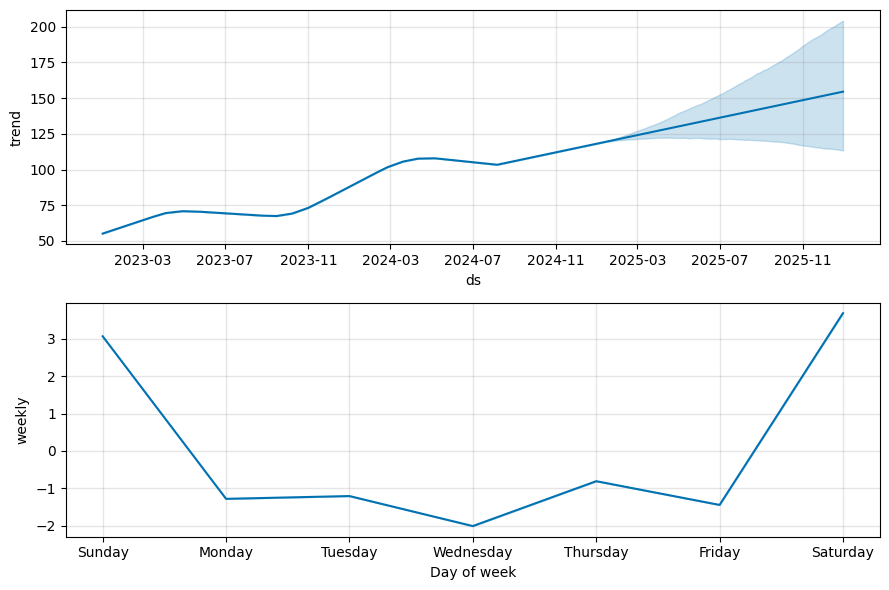

In [7]:
# [실습 답안 예시]

# 2. 컴포넌트(구성요소) 분해 시각화
fig2 = m.plot_components(forecast)
plt.show()

# 해석:
# - Trend: 장기적으로 환자 수가 꾸준히 증가하고 있음을 보여준다.
# - Weekly: 토요일(Saturday)에 가장 높고, 수요일(Wednesday)에 가장 낮다. -> 주말 인력 보강 필요
# - Yearly: 8월경과 1월경에 정점을 찍는다. -> 여름 휴가철 사고, 겨울철 질환